# Python for Community Analysis

* Visualization
* Analysis


## Visualization

### Population Change

* MIDT (now just IDT)
* Visuals for explaining urban issues


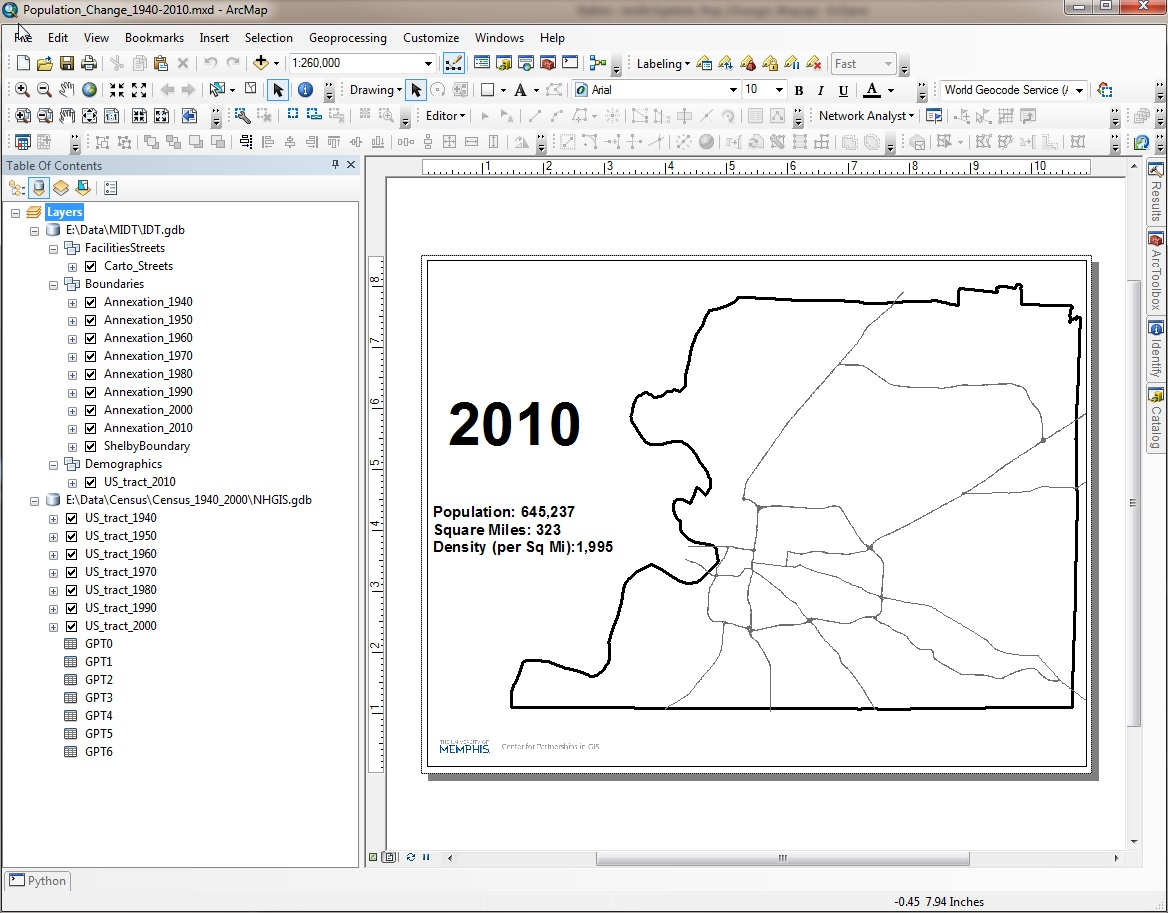

In [6]:
import IPython.display as disp
disp.Image('../data/pop_chg_map.jpg')

In [ ]:
import arcpy

mxd = arcpy.mapping.MapDocument("e:\data\midt\maps\Pop_Change_1960-2010.mxd")

outpath = 'e:\data\midt\exports\chamber\\'

lyrs = arcpy.mapping.ListLayers(mxd)
for lyr in lyrs:
    if lyr.isGroupLayer:
        print lyr.name
        lyr.visible = True        
        grp_lyrs = arcpy.mapping.ListLayers(lyr)      
        city_boundary = grp_lyrs[1]
        pop_data = grp_lyrs[2]
        
        for elem in arcpy.mapping.ListLayoutElements(mxd, "TEXT_ELEMENT"):
            if elem.name == 'date':
                elem.text = lyr.name
                elem.elementPositionX = 0.6502
                elem.elementPositionY = 6.5719
            elif elem.name == 'poptotals':
                arcpy.SelectLayerByLocation_management(pop_data.longName, 
                                                       "HAVE_THEIR_CENTER_IN", 
                                                        city_boundary, 
                                                        selection_type="NEW_SELECTION")                
                tbl = arcpy.Frequency_analysis(pop_data.longName, "in_memory", 
                                               frequency_fields="County", 
                                               summary_fields="POP")                
                arcpy.SelectLayerByAttribute_management(pop_data, 
                                                        selection_type="CLEAR_SELECTION")
                
                for row in arcpy.da.SearchCursor(tbl,"POP"):
                    tot_pop = row[0]                    
                for row in arcpy.da.SearchCursor(city_boundary, "Shape_Area"):
                    tot_area = row[0]
                    sqmi = tot_area/27878400 
    
                pop_density = int(tot_pop/(sqmi))
        
                elem.text = """"Population (25 people per dot): \
                            {:,}\nSquare Miles: {:,}\nDensity(per Sq Mi): \
                            {:,}""".format(int(tot_pop),int(sqmi),pop_density)
            
                elem.elementPositionX = 0.2016
                elem.elementPositionY = 4.0835
                
        arcpy.mapping.ExportToJPEG(mxd, outpath + lyr.name, resolution=300)
        lyr.visible = False

In [1]:
import IPython.display as disp
disp.Image(url='http://bit.ly/1MmivWM')

## Neighborhood Design

* ULI Presentation on 20th anniversary of Harbor Town
* Utilized physical data to evaluate correlation between design and property values
* Analyzed property appraisals from 2003 to 2014

### Libraries used

In [ ]:
import os
import arcpy
import collections
from caeser.utils import inflate, cursor_to_namedtuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib
from sklearn import preprocessing
from matplotlib.font_manager import FontProperties

### Data used

In [ ]:
intersections = 'TeleAtlas_Intersections' #Created from different process
streets = 'TeleAtlas_Streets'
nbhd_list = pd.read_csv('neighborhood_list.csv')
pardat14 = pd.read_csv('PARDAT14.txt')
pardat14.idx = pardat14.PARID  #reset index value to use parcel id
pardat03 = pd.read_csv('PARDAT03.txt')
pardat03.idx = pardat03.PARID  #reset index value to use parcel id


### Spatial operations

In [ ]:
for hood in nbhd_list.NAME:
    new_fields = ['du', 'intersection', 'stmiles', 'intdensity', 'stdensity']
    Fields = collections.namedtuple('Fields', new_fields)
    vals = collections.defaultdict(list) 
    vals[hood] = Fields(du = None, stmiles = None, intersection = None,
                        intdensity = None, stdensity = None)
    
    for field in new_fields:
        if not field in list(arcpy.ListFields(nbhd)):
            arcpy.AddField_management(nbhd, field, 'DOUBLE')
    
    where = """NAME = '{}'""".format(hood.replace("'", '"'))       
    arcpy.MakeFeatureLayer_management(nbhd, 'hood', where)  
    print where
    
    #process dwelling units
    pars = arcpy.MakeFeatureLayer_management(p14, 'pars')  
    pars_select = arcpy.SelectLayerByLocation_management(pars, 
                                                         'HAVE_THEIR_CENTER_IN', 
                                                         'hood')
    pars_select_arr = arcpy.da.FeatureClassToNumPyArray(pars_select, 
                                                        ['PARCELID', 'SHAPE@AREA'])
    
    #convert sqft to acres
    pars_select_arr['SHAPE@AREA'] = pars_select_arr['SHAPE@AREA'] / 43560  
    pars_select_df = pd.DataFrame.from_records(pars_select_arr)    
    
    #create subset from parcelids in selection
    pardat14_select = pd.merge(pardat14, pars_select_df, left_on = 'PARID', 
                               right_on = 'PARCELID')    
    pardat14_select.rename(columns={'SHAPE@AREA':'AREA'}, inplace = True)

    for fc in [intersections, streets]:
        clip_feat = arcpy.Clip_analysis(fc,'hood', 'in_memory')
        
        if fc == intersections:
            count = arcpy.GetCount_management(clip_feat)
            vals[hood] = vals[hood]._replace(intersection = int(count.getOutput(0)))
        else:
            fc_arr = arcpy.da.FeatureClassToNumPyArray(clip_feat, "Shape_Length")
            vals[hood] = vals[hood]._replace(stmiles = fc_arr["Shape_Length"].sum() / 5280)

    cur = arcpy.da.UpdateCursor(nbhd, '*', where)
    for row in cursor_to_namedtuple(cur):
        print row.NAME
        row = row._replace(intersection = vals[hood].intersection)
        row = row._replace(stmiles= vals[hood].stmiles)
        row = row._replace(du = pardat14_select.LIVUNIT.sum() / row.SQMI)
        row = row._replace(intdensity = vals[hood].intersection / row.SQMI)
        row = row._replace(stdensity = vals[hood].stmiles / row.SQMI)
        cur.updateRow(row)

### Plots

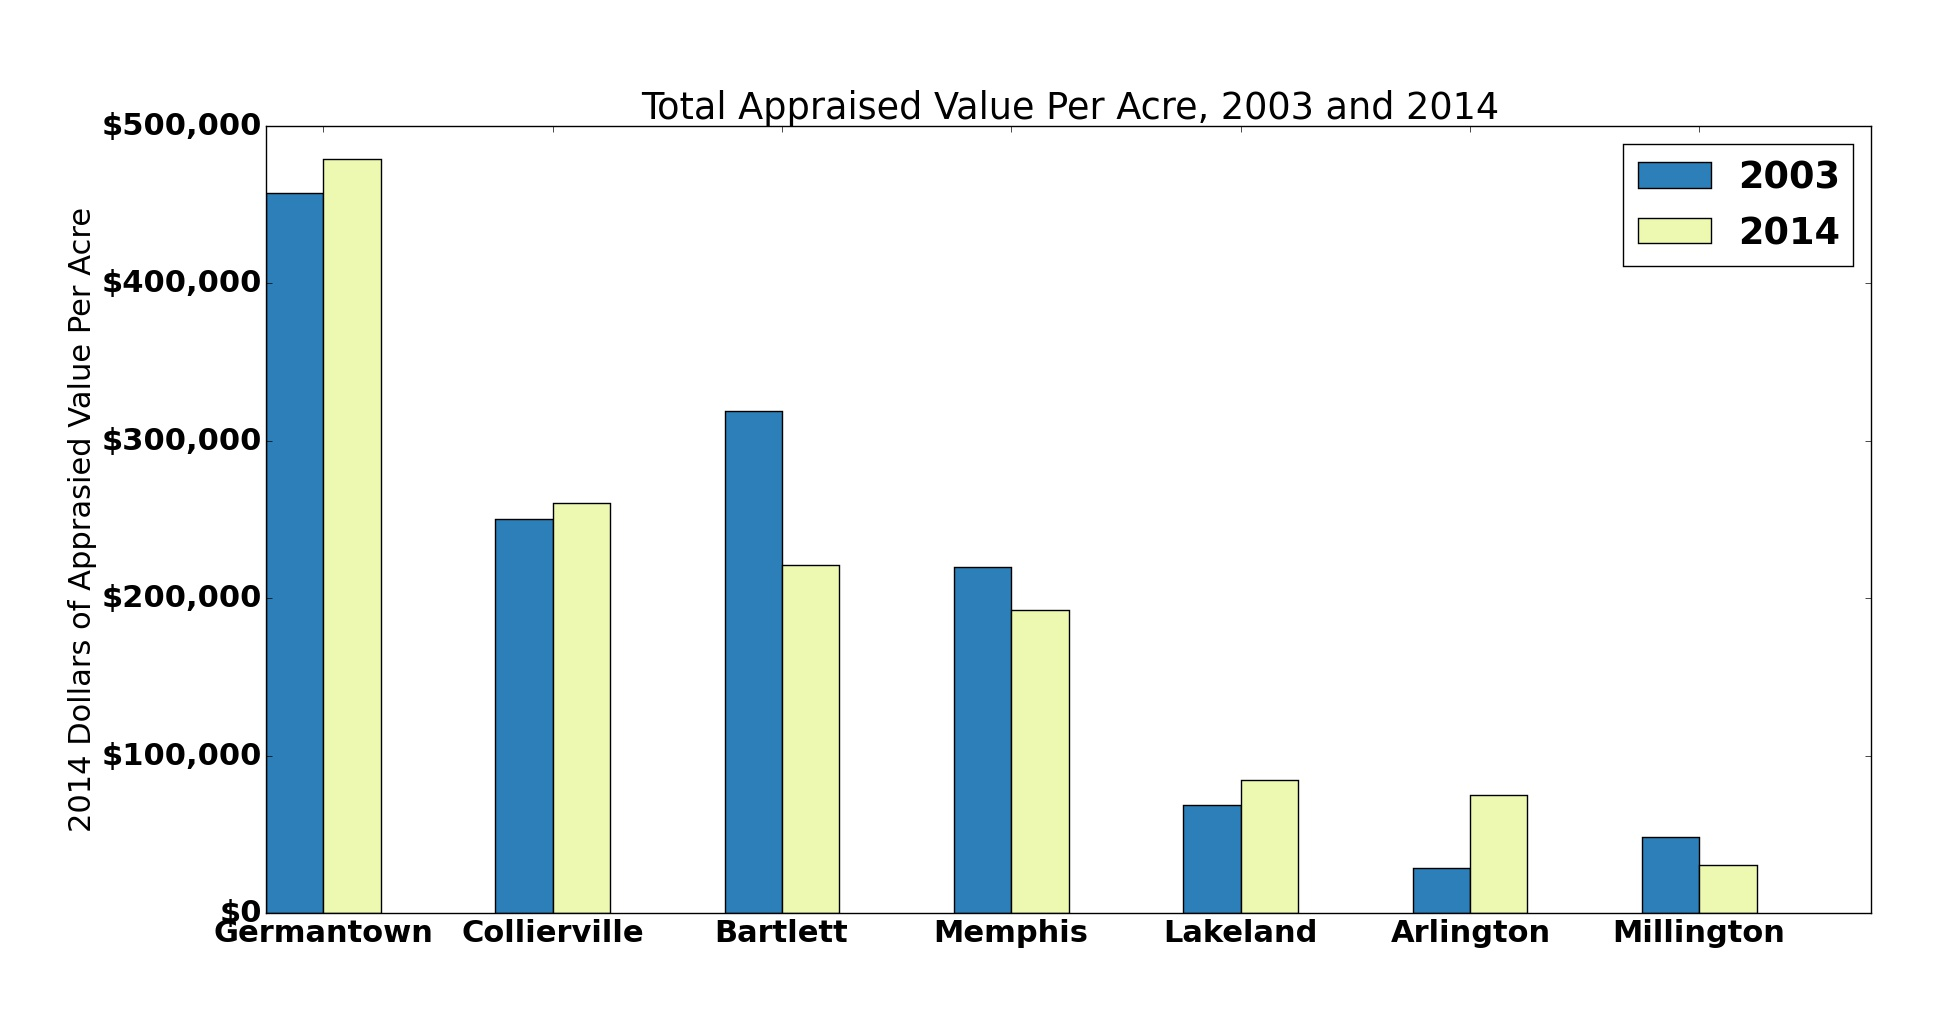

In [7]:
import IPython.display as disp
disp.Image('../data/appraised_value_city_only.jpeg')

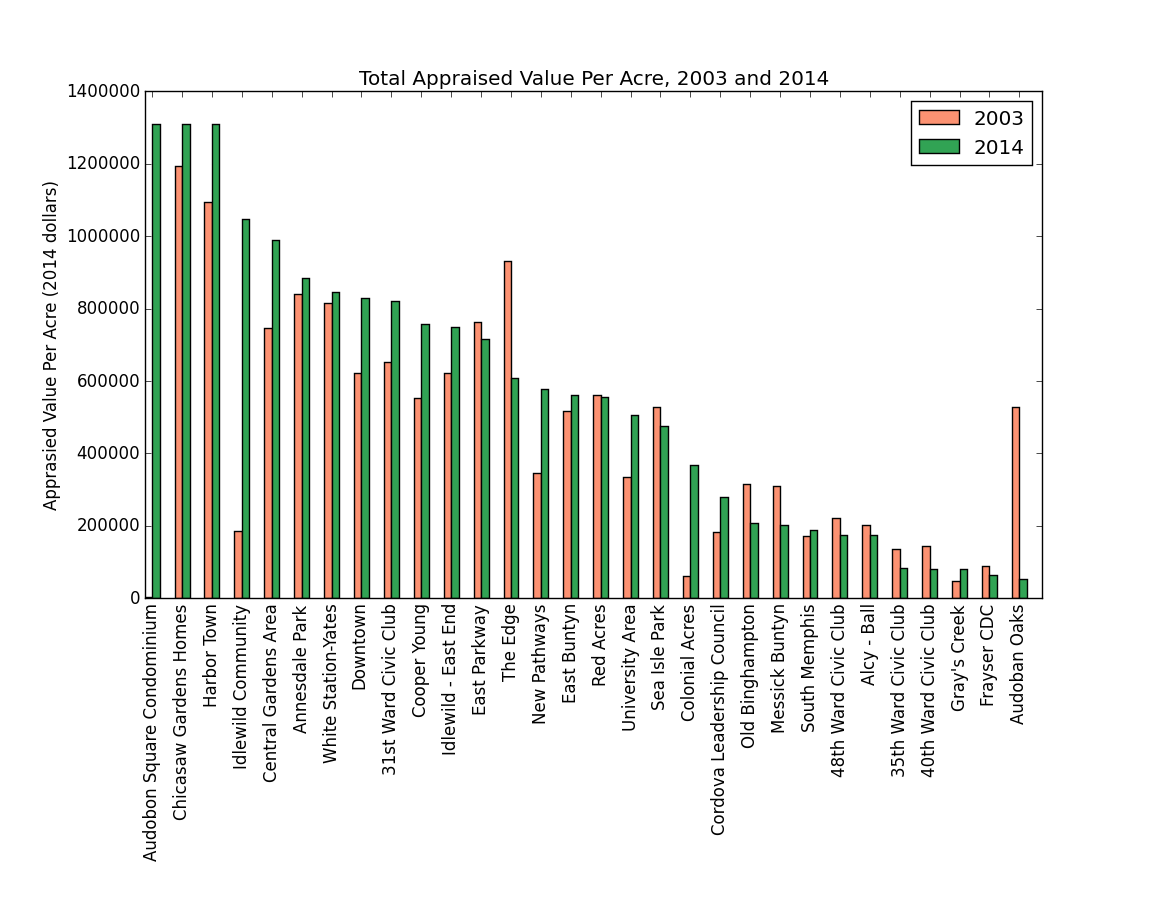

In [8]:
import IPython.display as disp
disp.Image('../data/neighborhood_comparison.png')

### Total Appraisal per Acre by Neighborhood

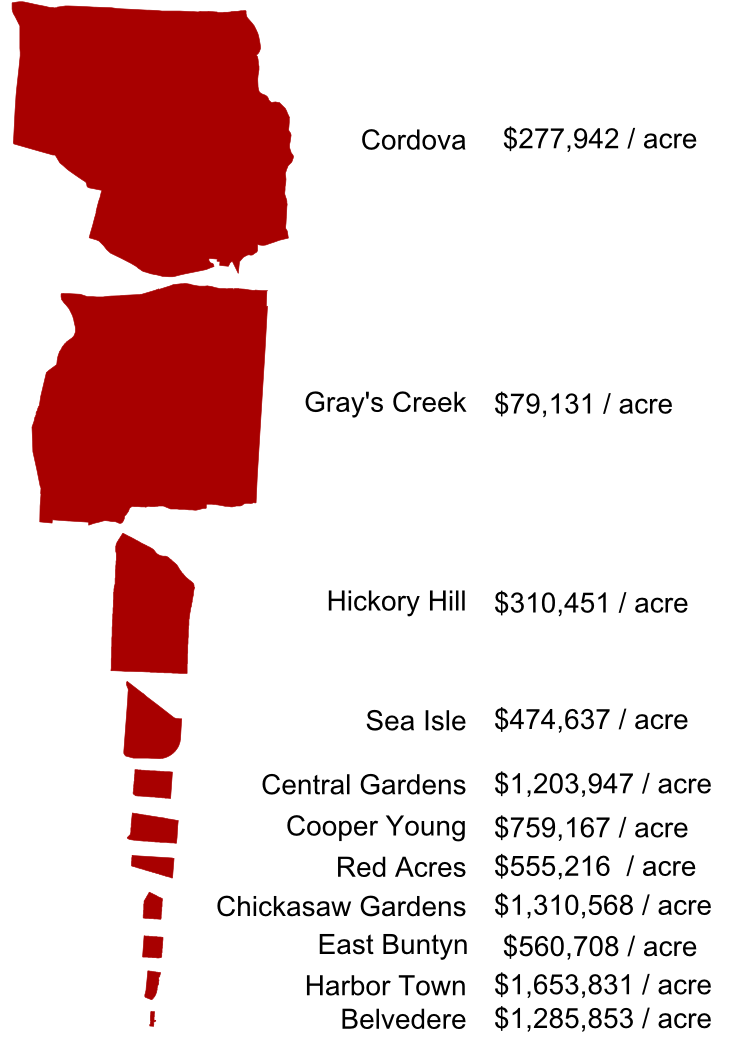

In [9]:
import IPython.display as disp
disp.Image('../data/Area_Comparison_values.png')

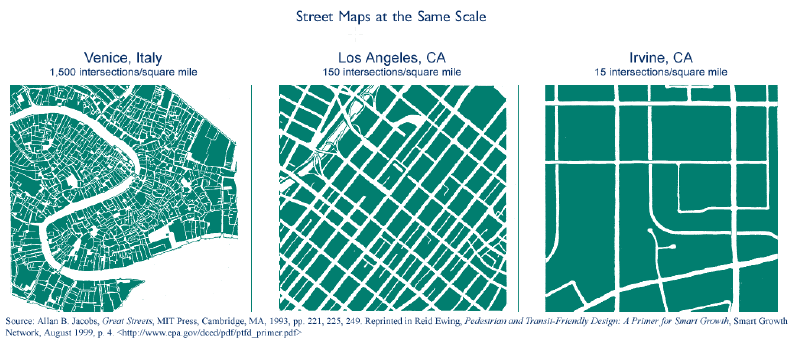

In [12]:
import IPython.display as disp
disp.Image('../data/intersection_density_intl.png')

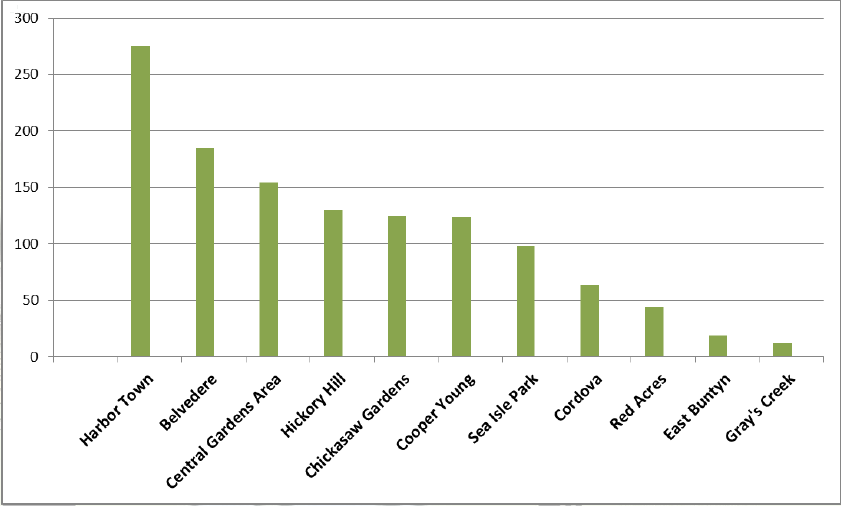

In [11]:
import IPython.display as disp
disp.Image('../data/intersection_density_memphis.png')

## Analysis

### Tax Delinquency

* Discrepency between how city and county pay taxes
* Mismatch between Assessor's data and county trustee
* Patterns in type of individuals/companies not paying taxes
* Challenges
    * Misspellings
    * Variations
    * Alternative names

### Libraries used


In [19]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import collections
import csv
import os
from fuzzywuzzy import fuzz
import string
import re

### Text matching: Variations

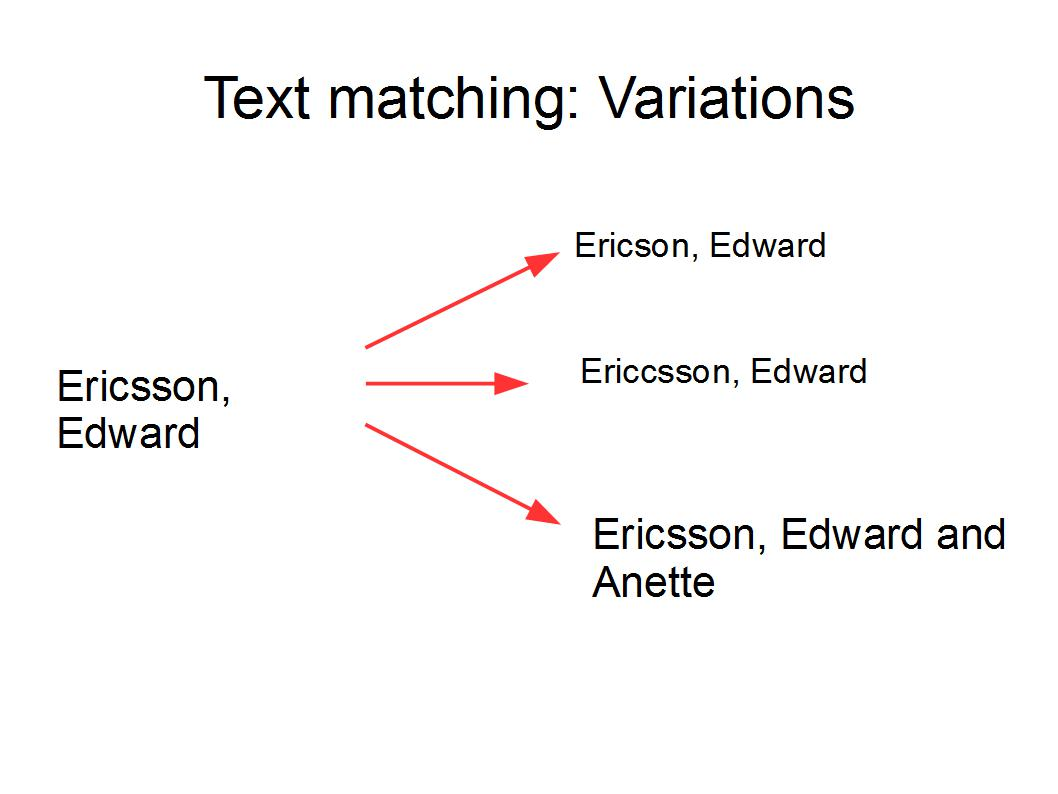

In [15]:
import IPython.display as disp
disp.Image('../data/tax_1.jpg')

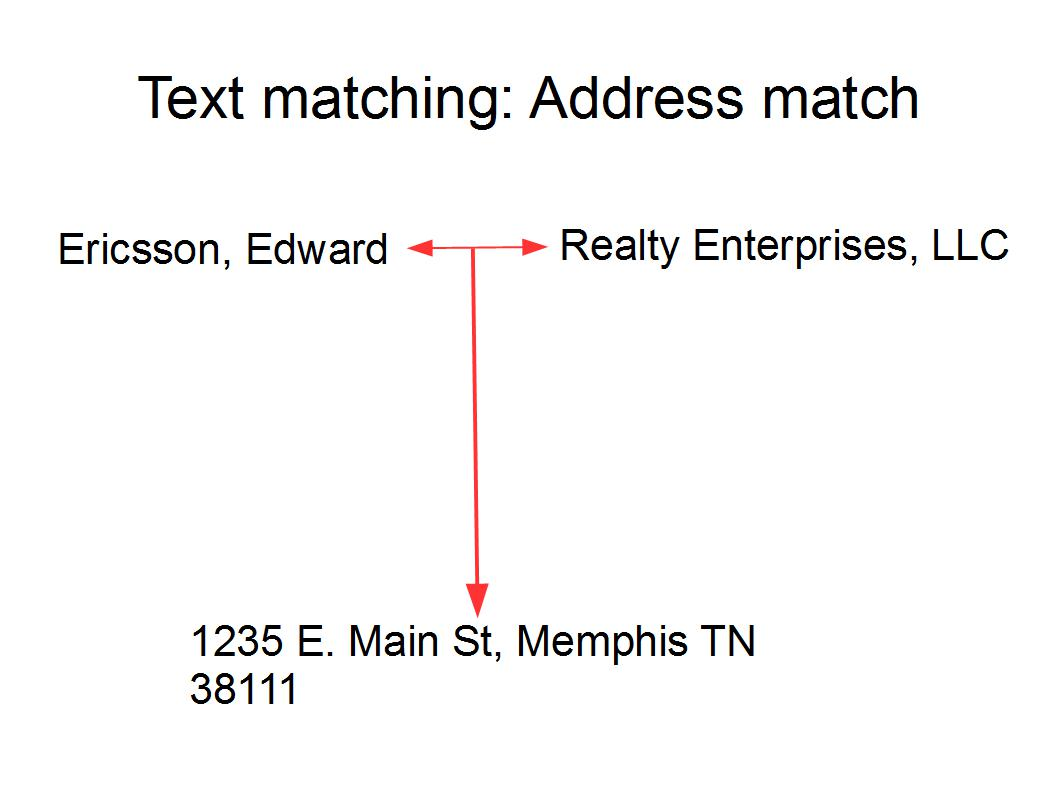

In [16]:
import IPython.display as disp
disp.Image('../data/tax_2.jpg')

In [26]:
def match_score(s1, s2):
    ratio = fuzz.ratio(s1,s2)
    token_ratio = fuzz.token_set_ratio(s1, s2)
    partial_ratio = fuzz.token_sort_ratio(s1,s2)
    avg = np.mean((ratio,token_ratio,partial_ratio))
    return avg   

def clean_string(st = ''):
    '''
    takes raw string from assessor's database and returns a standardized version
    in lower case without any punctuation
    '''
    st_split = st.split(' ')
    punctuation = string.punctuation
    st = ' '.join(str(s).lower().strip() for s in st_split if s != '')
    return re.sub('\s\s+',' ',re.sub('[{0}]'.format(punctuation),'', st))

def concat(*args):
    strs = [str(arg) for arg in args if not pd.isnull(arg)]
    return ' '.join(strs) 

np_concat = np.vectorize(concat)

In [ ]:
owndat = pd.read_csv('../data/owndat.csv', keep_default_na=False)
owndat = pd.read_csv('../data/owndat.csv',keep_default_na=False,
                     dtype={k:'str' for k in owndat.columns})

#string concatenation of addresss components
owndat['adrcomp'] = np_concat(owndat.ADRNO, owndat.ADRDIR, owndat.ADRSTR, 
                              owndat.ADRSUF, owndat.CITYNAME, owndat.STATECODE, 
                              owndat.ZIP1)

no_tax_list = pd.read_excel('../data/City Only Properties Available for TXS 2012 PY.xlsx')
no_tax_list['CityParcelNo'] = no_tax_list.apply(lambda x: x['CityParcelNo'].rstrip(), axis=1)
owndat = owndat[owndat.PARID.isin(no_tax_list.CityParcelNo)]#eliminate records not in no tax list



In [29]:
owndat.head()

,Unnamed: 0,PARID,OWN1,OWN2,ADRNO,ADRDIR,ADRSTR,ADRSUF,ADRSUF2,CITYNAME,...,UNITNO,UNITDESC,ADDR1,ADDR2,ADDR3,ZIP1,ZIP2,NOTE1,NOTE2,adrcomp
0,56,061018 00006,powell joe juanita,,1404,S,WILLETT,ST,,MEMPHIS,...,,,,,,38106,5032,,,1404 s willett st memphis tn 38106
1,223,012011 00038,lewis daryl,,,,P O BOX 300452,,,MEMPHIS,...,,,,,,38130,0452,ADDR CHG REC'D 10/14/10,,p o box 300452 memphis tn 38130
2,304,074090 G00010,siegfried russell,,5764,,RAYBEN,CIR,,MEMPHIS,...,,,,,,38115,2062,,,5764 rayben cir memphis tn 38115
3,343,027019 00013,inspirational ch of faith the trs,,653,,LEATH,ST,,MEMPHIS,...,,,,,,38107,4043,,,653 leath st memphis tn 38107
4,355,026005 00013,wright yolanda s and thedric e wright,and jada e w prather,1827,,FLAGLER,ST,,MCKEESPORT,...,,,,,,15132,4538,ADDR CHG REC'D 12/15/09,,1827 flagler st mckeesport pa 15132


In [30]:
no_tax_list.head()

,MinOfTaxYear,MaxOfTaxYear,CityParcelNo,CountyParcelNo,SumOfYearTotalAmountDue,SumOfTotalParcelBalance,LastOfLocationStreetNumber,LastOfOwnerZip,LastOfPropertyLocation,ParcelNo
0,2011,2014,001001 B00012,0010010B000120,2994.90,11979.60,79,38901,79 RIVERWALK PL,NaN
1,2012,2014,001001 I00035,0010010I000350,734.50,2203.50,0,38116,0 HARBOR BEND-MARINA SLIP E09,NaN
2,2012,2014,001001 J00034,0010010J000340,9006.10,27018.30,994,38103,994 RIVER CURRENTS DR,NaN
3,2009,2014,001001 S00003,0010010S000030,23335.72,303364.36,,38103,IN-LIEU OF TAX BILL,NaN
4,2009,2014,001001 S00005,0010010S000050,22572.38,293440.94,113,38103,113 HARBOR TOWN SQ UNIT 201,NaN


In [ ]:
#clean and standardize all strings to be used for comparison
owndat.adrcomp = owndat.adrcomp.apply(clean_string)
owndat.OWN1 = owndat.OWN1.apply(clean_string)
owndat.OWN2 = owndat.OWN2.apply(clean_string)
owndat.adrcomp = owndat.adrcomp.apply(clean_string)

owndat_sample = owndat
owndat_sample = owndat_sample.drop(['OWN2', 'ADRNO', 'ADRDIR', 'ADRSTR', 
                                    'ADRSUF', 'ADRSUF2', 'CITYNAME', 'STATECODE', 
                                    'UNITNO', 'UNITDESC', 'ADDR1', 'ADDR2', 
                                    'ADDR3', 'ZIP1', 'ZIP2', 'NOTE1', 'NOTE2'],axis=1)
owndat_sample['dummy'] = 0
df_dup = pd.merge(owndat_sample, owndat_sample, on='dummy')
del df_dup['dummy']

#remove records joined with themselves, results in 8281 records dropped
df_dup = df_dup[df_dup.OWN1_x != df_dup.OWN1_y]
"""create common key and drop instances where (B,A) == (A,B)
    commonality established by sorting and joining parcelid pairs
"""
df_dup['common_key'] = df_dup.apply(lambda x: ''.join(a for a in sorted([x['OWN1_x'],x['OWN1_y']])),axis=1)
df_dup = df_dup.drop_duplicates(['common_key'])
#match scores for owners and addresses
df_dup['own_distance'] = df_dup.apply(lambda r: match_score(r['OWN1_x'], r['OWN1_y']), axis=1)
df_dup['adr_distance'] = df_dup.apply(lambda r: match_score(r['adrcomp_x'], r['adrcomp_y']), axis=1)

q = '(adr_distance >= 85 & (adr_distance >= 95 & adr_distance < 100)) | adr_distance == 100'
df_select = df_dup.query(q)

In [33]:
own_corrected = pd.read_csv('../data/draft_duplicates_corrected.csv')

own_corrected.head()

,ID,PARID_x,PARID_y,OWN1_x,OWN1_y,adrcomp_x,adrcomp_y,own_distance,adr_distance,correct
0,153,061018 00006,031011 00009,powell joe juanita,powell joe jr juanita s,1404 s willett st memphis tn 38106,1404 s willett st memphis tn 38106,92.000000,100,1
1,791,061018 00006,031015 00003,powell joe juanita,powell joseph juanita s,1404 s willett st memphis tn 38106,1404 s willett st memphis tn 38106,88.000000,100,1
2,55455,075160 00003,078041 00015,m e g capital management corp,m e g capital management inc,815 n la brea ave inglewood ca 90302,815 n la brea ave inglewood ca 90302,89.000000,100,1
3,56098,075160 00003,075111 00035,m e g capital management corp,meg capital management corp,815 n la brea ave inglewood ca 90302,815 n la brea ave inglewood ca 90302,90.333333,100,1
4,56766,075160 00003,082024 00011,m e g capital management corp,meg captial management,815 n la brea ave inglewood ca 90302,815 n la brea ave inglewood ca 90302,75.666667,100,1


In [34]:
llcs = pd.read_csv('../data/llcs.csv')

llcs.head()

,Unnamed: 0,ID,PARID_x,PARID_y,OWN1_x,OWN1_y,adrcomp_x,adrcomp_y,own_distance,adr_distance,correct
0,11,214362,079067 A00009,075140 A00078,davis willie jr,davis rebecca etal,2030 mcpherson rd memphis tn 38116,2030 mcpherson rd memphis tn 38116,48.666667,100,1
1,15,384018,075018 00071,032013 00030,foster david b,rock investment group,3187 toby ln memphis tn 38111,3187 toby ln memphis tn 38111,32.333333,100,1
2,25,663494,023016 00042C,060079 00100,arnold willie j,ivy eva d,1849 meadowhill memphis tn 38106,1849 meadowhill memphis tn 38106,30.333333,100,1
3,36,750624,028032 00004C,028024 00009,g g properties l p,gross charles w and charles e gross,2268 madison ave memphis tn 38104,2268 madison ave memphis tn 38104,35.333333,100,1
4,39,1046005,058095 00031,082001 00098,phildax properties pso,landshof robert,p o box 383287 germantown tn 38183,p o box 383287 germantown tn 38183,43.000000,100,1


### Takeaways

* Multiple property delinquencies
* Hidden owners
* Ownership
* Targeted recovery

In [51]:
from IPython.core.display import HTML
HTML('<iframe src=http://arcg.is/1OqC1ES width=1000 height=1000></iframe>')